In [45]:
# Revised build v0.4.1
# Changelog:
# Added function for GPS to Cartesian Coordinate Converter
# Added optional function for Cartesian to GPS Converter
# Code now converts GPS coordinates of GNodes and Actual Position to Cartesian coordinates
# Removed function for Average Filter and associated lines of code
# Removed Average Filter from CSV output
    # Removed Mean Distances w/ Average Filter in Basic.csv
    # Removed Distances w/ Average Filter in Distances.csv
# Added Tolerance Filter in CSV output
    # Added Mean Coordinates w/ Tolerance Filter in Basic.csv
    # Added Coordinates w/ Tolerance Filter in Coordinates.csv
    # Added K-Means Centroids vs. Mean Coordinates w/ Tolerance Filter in K-Means.csv
    # Added K-Means Centroids vs. Coordinates w/ Tolerance Filter in K-Means.csv
    # Minor formatting changes in CSV ouptuts for better visualization

# Revised build v0.4.2
# Changelog:
# Added error function with revised input and output
# Added plot for data frequency distribution table with all three gateways
# Added import pandas and seaborn as it was used for this

# Revised build v0.4.3
# Changelog:
# Removed phoneA[0:len(phoneA)]
# Disabled frequency distribution (Error is column length does not match)

# new libraries:
# pip install pandas
# pip install pyproj
# pip install scipy
# pip install seaborn
# pip install sklearn

# Revised build v0.4.4
# Changelog:
# Changed axes names of distance behavior graph
# Added actual distance in distance behavior graph
# Changed legend location in distance behavior graph for better visualization
# Created a new function for comp_distanceAf, comp_distanceBf, and comp_distanceCf called actualDist

# Revised build v0.4.5
# Changelog:
# Enabled frequency distribution
# Fixed syntax error in frequency distribution graph code

In [46]:
# Import Code
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from kneed import KneeLocator
from scipy.optimize import *
import serial
import time
import math
from math import radians, cos, sin, asin, sqrt
from datetime import datetime as dt
import csv
from pyproj import CRS, Transformer
import pandas as pd
import seaborn as sns

In [47]:
# Variable declarations
port = 'com19'
baud = 115200

ts = time.localtime() #update time

#Define variables for use
distanceA = list()
distanceB = list()
distanceC = list()
okA = 0
okB = 0
okC = 0
ok = 0
phoneA = 0
phoneB = 1
phoneC = 2

###### CHANGE THIS FOR YOUR DIRECTORY
save_destination = "D:\\User Files\\Yani\\Desktop\\LoRa Rescue Data\\"

# Distance calculation constants
n = 3.2
dro = 1.5
roRSSI = -32

#Trilateration calculation constants
# GNode Coordinates
# Format: A B C
xg = np.array([0,0,0])
yg = np.array([0,0,0])
# GNode Position
# Format: A B C
latg = np.array([14.687079,14.687085,14.686586])
longg = np.array([121.074557,121.075146,121.074825])
# Actual Node Coordinates
xAct = np.array([0])    #Target x-coordinate
yAct = np.array([0])    #Target y-coordinate
# Actual Node Position
longAct = np.array([121.074731])
latAct = np.array([14.686970])
# For filtering
errorTolerance = 50

In [48]:
# Function Declarations
def listenForData(port,baud):
    #Define variables for use
    print("listening to port "+str(port)+" at "+str(baud))
    arduino = serial.Serial(port, baud)
    rssiA = list()
    rssiB = list()
    rssiC = list()
    phoneA = 0
    phoneB = 0
    phoneC = 0
    okA = 0
    okB = 0
    okC = 0
    ok = 0

    while ok == 0: #will wait until ok is 1. 'ok' will only be 1 when A B C are matching.
        arduino_raw_data = arduino.readline() #read serial data
        decoded_data = str(arduino_raw_data.decode("utf-8")) #convert to utf-8
        data = decoded_data.replace('\n','') #remove \n in the decoded data
        data = data.replace('\r','')
        gatewayID = data[:1] #get gateway ID
        dataID = data[1:2] #get data ID
        data = data[2:] #get data
        if gatewayID == 'A':
            if dataID == '1':
                phoneA = data
                print("\nReceiving Gateway A: 0" + phoneA)
            elif dataID == '2':
                rssiA.append(float(data))
            elif dataID == '3':
                ts = time.localtime() #update time
                timeA = time.strftime("%X", ts) #set timeA to current time
                print("timeA: " + timeA)
                dtn = str(dt.now())
                dtn = dtn[0:19]
                dtn = dtn.replace(':',';')
                rssiA = np.delete(rssiA,len(rssiA)-1)
                rssiA = np.delete(rssiA,len(rssiA)-1)
                okA = 1
        elif gatewayID == 'B':
            if dataID == '1':
                phoneB = data
                print("\nReceiving Gateway B: 0" + phoneB)
            elif dataID == '2':
                rssiB.append(float(data))
            elif dataID == '3':
                ts = time.localtime() #update time
                timeB = time.strftime("%X", ts) #set timeA to current time
                print("timeB: " + timeB)
                rssiB = np.delete(rssiB,len(rssiB)-1)
                rssiB = np.delete(rssiB,len(rssiB)-1)
                okB = 1
        elif gatewayID == 'C':
            if dataID == '1':
                phoneC = data
                print("\nReceiving Gateway C: 0" + phoneC)
            if dataID == '2':
                rssiC.append(float(data))
            if dataID == '3':
                ts = time.localtime() #update time
                timeC = time.strftime("%X", ts) #set timeA to current time
                print("timeC: " + timeC)
                rssiC = np.delete(rssiC,len(rssiC)-1)
                rssiC = np.delete(rssiC,len(rssiC)-1)
                okC = 1
        # Write to CSV, note if data matches
        if phoneA == phoneB == phoneC and okA == 1 and okB == 1 and okC == 1:
            with open(save_destination+'rawData.csv', mode='a') as logs:
                logswrite = csv.writer(logs, dialect='excel', lineterminator='\n')
                logswrite.writerow(['Phone','Time','Gateway A','Gateway B','Gateway C'])
                for i in range(len(rssiA)):
                    logswrite.writerow([phoneA,timeA,rssiA[i],rssiB[i],rssiC[i]])
            start_dt = dt.strptime(timeA, '%H:%M:%S')
            end_dt = dt.strptime(timeC, '%H:%M:%S')
            diff = abs(end_dt - start_dt)
            print("\nA, B, and C received successfully with interval of "+str(diff))
            ok = 1
        elif okA == 1 and okB == 1 and okC == 1:
            print("\nError: Data mismatch, dumping date into error.csv")
            with open(save_destination+'error.csv', mode='a') as logs:
                logswrite = csv.writer(logs, dialect='excel', lineterminator='\n')
                logswrite.writerow(['Time','Gateway A','Gateway B','Gateway C'])
                for i in range(len(rssiA)):
                    logswrite.writerow([phoneA,timeA,rssiA[i],rssiB[i],rssiC[i]])
            rssiA = list()
            rssiB = list()
            rssiC = list()
    return rssiA, rssiB, rssiC, dtn, phoneA #return the variables

def importCSV():
    distanceAf = list()
    distanceBf = list()
    distanceCf = list()
    with open(save_destination+'gatewayAt.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        
        for row in csv_reader:
            if line_count == 0:
                phoneA = row[1]
            elif line_count > 0 and line_count < 59:
                distanceAf.append(row[1])
            elif line_count == 61:
                dtn = row[1]
                dtn = dtn.replace(':',';')
            line_count += 1
    with open(save_destination+'gatewayBt.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count > 0 and line_count < 59:
                distanceBf.append(row[1])
            line_count += 1
    with open(save_destination+'gatewayCt.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count > 0 and line_count < 59:
                distanceCf.append(row[1])
            line_count += 1
    return distanceAf, distanceBf, distanceCf, dtn, phoneA

def rssiToDist(rssiA,rssiB,rssiC,n,dro,roRSSI):
    distA = list()
    distB = list()
    distC = list()
    rssi = [rssiA,rssiB,rssiC]
    for i in range(len(rssi[0])):
        distA.append(pow(10,((roRSSI-int(rssi[0][i]))/(10*n)))*dro)
        distB.append(pow(10,((roRSSI-int(rssi[1][i]))/(10*n)))*dro)
        distC.append(pow(10,((roRSSI-int(rssi[2][i]))/(10*n)))*dro)
    return distA,distB,distC

def rotateGraph(xg, yg, xAct, yAct):
    def getBcoor(z):
        x = z[0]
        y = z[1]

        F = np.empty((2))
        F[0] = (x**2) + (y**2) - (Rab**2)
        F[1] = ((x-xg[2])**2) + (y**2) - (Rbc**2)
        return F
    def getNcoor(z):
        x = z[0]
        y = z[1]

        F = np.empty((2))
        F[0] = (x**2) + (y**2) - (Ran**2)
        F[1] = ((x-xg[2])**2) + (y**2) - (Rnc**2)
        return F
    zGuess = np.array([1,1])
    if yg[2] != 0:
        notFlat = 1
        xg[2] = -np.sqrt((xg[2]**2)+(yg[2]**2))
        yg[2] = 0
        
        z = fsolve(getBcoor,zGuess)
        xg[1] = z[0]
        yg[1] = -z[1]
        z = fsolve(getNcoor,zGuess)
        xAct = z[0]
        yAct = z[1]
    else:
        notFlat = 0
    return xg, yg, xAct, yAct, notFlat

def trilaterate(distanceAf,distanceBf,distanceCf,xg,yg):
    A = -2*xg[0]+2*xg[1]
    B = -2*yg[0]+2*yg[1]
    C = distanceAf**2-distanceBf**2-xg[0]**2+xg[1]**2-yg[0]**2+yg[1]**2
    D = -2*xg[1]+2*xg[2]
    E = -2*yg[1]+2*yg[2]
    F = distanceBf**2-distanceCf**2-xg[1]**2+xg[2]**2-yg[1]**2+yg[2]**2
    x = (C*E-F*B)/(E*A-B*D)
    y = (C*D-A*F)/(B*D-A*E)
    return x,y

# Coordinate Filter
def tolFilter(x,y,errorTolerance):
    i = 0
    while i != 60:
        if i == len(y):
            i = 60
            continue
        e = 0
        dist = np.sqrt(((xAve-x[i])**2)+((yAve-y[i])**2))
        if dist >= errorTolerance:
            #print(str(i)+" - Deleted"+' '+str(x[i])+' '+str(y[i]))
            x = np.delete(x,i)
            y = np.delete(y,i)
        else:
            #print(str(i)+' '+str(x[i])+' '+str(y[i]))
            i += 1
    return x,y

def kmeansOptimize(data):
    # Compute for inertias for every possible number of clusters
    inertia = [] #aka Sum of Squared Distance Errors
    for i in range(1,len(data)):
        kmeans = KMeans(n_clusters=i).fit(data)
        inertia.append(kmeans.inertia_)

    #Determine optimal Number of Clusters based on Elbow
    elbow = KneeLocator(range(1,len(data)),inertia, curve='convex', direction='decreasing')

    #Perform K-means with elbow no. of clusters
    kmeans = KMeans(n_clusters=elbow.knee, n_init=5).fit(data)

    return kmeans,inertia,elbow

def haversine(lat1, lon1, lat2, lon2):

    miles = 3959.87433
    meters = 6372.8*1000

    R = meters

    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))

    distance = R * c

    return distance

def GPSToCart(lat,lon):
    # Convert GPS Coordinates to Cartesian Coordinates
    # For manual checking, refer to https://epsg.io/transform#s_srs=4326&t_srs=25391 
    # Defining CRS aka Coordinate Reference Systems
    inCRS = CRS.from_epsg(4326) #CRS of GPS that uses Latitude and Longitude Values
    outCRS = CRS.from_epsg(25391) #Luzon Datum of 1911 utilizing Transverse Mercator Project Map

    #Conversion from GPS Coordinates to Philippine Cartesian Coordinates
    GeoToCart = Transformer.from_crs(inCRS,outCRS)
    x,y = GeoToCart.transform(lat,lon) #Format should be (lat,lon) for epsg:4326

    
    return x,y

def cartToGPS(x,y):
    # Convert Cartesian Coordinates back to GPS Coordinates
    # For manual checking, refer to https://epsg.io/transform#s_srs=25391&t_srs=4326 
    # Defining CRS aka Coordinate Reference Systems
    inCRS = CRS.from_epsg(4326) #CRS of GPS that uses Latitude and Longitude Values
    outCRS = CRS.from_epsg(25391) #Luzon Datum of 1911 utilizing Transverse Mercator Project Map

    #Conversion from Philippine Cartesian back to GPS Coordinates Coordinates
    CartToGeo = Transformer.from_crs(outCRS,inCRS)
    lat, lon = CartToGeo.transform(x,y) #Format should be (x,y) for epsg:25391

    return lat, lon

def errorcomp(x, y, xAct, yAct, kmeans, xAve, yAve, data):
    compVact = list()
    for i in range(len(x)):
        compVact.append(np.sqrt((x[i]-xAct)**2+(y[i]-yAct)**2))

    #K-means centroid vs. Average Point (dataset average)
    centVave = np.sqrt((kmeans.cluster_centers_[:,0]-xAve)**2+(kmeans.cluster_centers_[:,1]-yAve)**2)

    #Computed Position vs. K-means centroid
    compVcent = np.sqrt([(data[:,0]-kmeans.cluster_centers_[0,0])**2+(data[:,1]-kmeans.cluster_centers_[0,1])**2])
    for i in range(1,len(kmeans.cluster_centers_)):
        distance = np.sqrt([(data[:,0]-kmeans.cluster_centers_[i,0])**2+(data[:,1]-kmeans.cluster_centers_[i,1])**2])
        compVcent = np.append(compVcent,distance,axis=0)

    return compVact, centVave, compVcent

def actualDist(xAct, yAct, xg, yg):
    #Computed distanceAf, Bf, Cf
    comp_distanceAf = list()
    comp_distanceBf = list()
    comp_distanceCf = list()
    comp_distanceAf = np.sqrt(((xAct-xg[0])**2)+((yAct-yg[0])**2))
    comp_distanceBf = np.sqrt(((xAct-xg[1])**2)+((yAct-yg[1])**2))
    comp_distanceCf = np.sqrt(((xAct-xg[2])**2)+((yAct-yg[2])**2))

    return comp_distanceAf, comp_distanceBf, comp_distanceCf

In [49]:
# Listen to COM port and check for errors
# rssiA, rssiB, rssiC, dtn, phoneA = listenForData(port,baud)
# For testing import CSVs from gatewayAt etc. *note: all of the imported data are in distances already
distanceAf, distanceBf, distanceCf, dtn, phoneA = importCSV()

In [50]:
#Convert RSSI to Distance
# comment if using imported data
#distanceAf, distanceBf, distanceCf = rssiToDist(rssiA,rssiB,rssiC,n,dro,roRSSI)

#Convert GPS Coordinates to Cartesian Coordinates
xg,yg = GPSToCart(latg,longg)
xAct,yAct = GPSToCart(latAct,longAct)

In [51]:
# Trilateration Part of the Code
for i in range(len(distanceAf)):
    distanceAf[i] = float(distanceAf[i])
    distanceBf[i] = float(distanceBf[i])
    distanceCf[i] = float(distanceCf[i])
# Convert Distances from each GNode to numpy arrays
distanceAf = np.array(distanceAf)
distanceBf = np.array(distanceBf)
distanceCf = np.array(distanceCf)
# Get average distances
AfAve = sum(distanceAf)/len(distanceAf)
BfAve = sum(distanceBf)/len(distanceBf)
CfAve = sum(distanceCf)/len(distanceCf)
# Rotate Graph, comment if not needed
# xg, yg, xAct, yAct, notFlat = rotateGraph(xg, yg, xAct, yAct)

# Trilaterate Data
print("Trilaterating Data...\n")
x,y = trilaterate(distanceAf,distanceBf,distanceCf,xg,yg)
xAve,yAve = trilaterate(AfAve,BfAve,CfAve,xg,yg)

# Tolerance Filter
xFilt,yFilt = tolFilter(x,y,errorTolerance)
# Mean Coordinates after Tolerance Filter
xFiltAve = np.mean(xFilt)
yFiltAve = np.mean(yFilt)


Trilaterating Data...



In [52]:
#Compute actual distance of phone node to GNodes
comp_distanceAf, comp_distanceBf, comp_distanceCf = actualDist(xAct, yAct, xg, yg)

<Figure size 432x288 with 0 Axes>

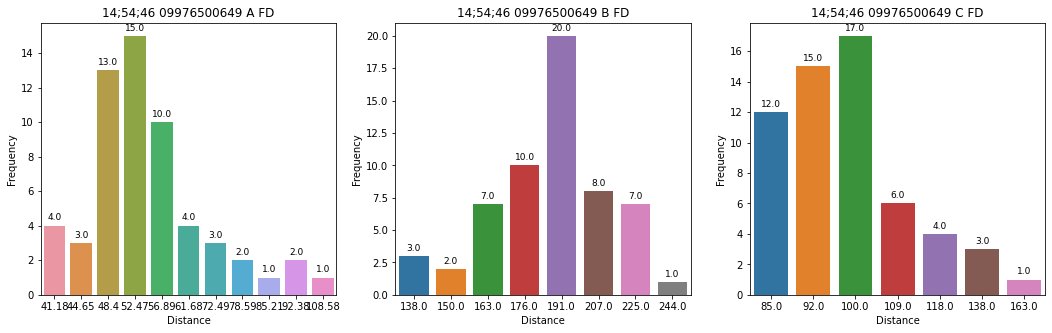

In [53]:
# Plot the data frequency of the gateways
fig = 1
plt.figure(fig)
distSeriesA = pd.Series(distanceAf).value_counts().reset_index().sort_values('index').reset_index(drop=True)
distSeriesA.columns = ['Distance','Frequency']
distSeriesB = pd.Series(distanceBf).value_counts().reset_index().sort_values('index').reset_index(drop=True)
distSeriesB.columns = ['Distance','Frequency']
distSeriesB['Distance'] = distSeriesB['Distance'].round()
distSeriesC = pd.Series(distanceCf).value_counts().reset_index().sort_values('index').reset_index(drop=True)
distSeriesC.columns = ['Distance','Frequency']
distSeriesC['Distance'] = distSeriesC['Distance'].round()
figur, axes = plt.subplots(1,3, figsize=(18, 5))
axes[0].set_title(dtn + ' 0' + phoneA  + ' A FD')
plots = sns.barplot(ax=axes[0],x="Distance", y="Frequency", data=distSeriesA)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.1f'), 
                    (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                    size=9, xytext=(0, 8),
                    textcoords='offset points')

axes[1].set_title(dtn + ' 0' + phoneA  + ' B FD')
plots = sns.barplot(ax=axes[1],x="Distance", y="Frequency", data=distSeriesB)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.1f'), 
                    (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                    size=9, xytext=(0, 8),
                    textcoords='offset points')

axes[2].set_title(dtn + ' 0' + phoneA  + ' C FD')
plots = sns.barplot(ax=axes[2],x="Distance", y="Frequency", data=distSeriesC)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.1f'), 
                    (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                    size=9, xytext=(0, 8),
                    textcoords='offset points')

plt.savefig(save_destination + dtn + ' 0' + phoneA + ' FrequencyDistribution.jpg')
fig += 1

In [54]:
#For the .py file exclusively, the DB graph unexpectedly mixes with the FD graph without plt.close()
plt.close() 

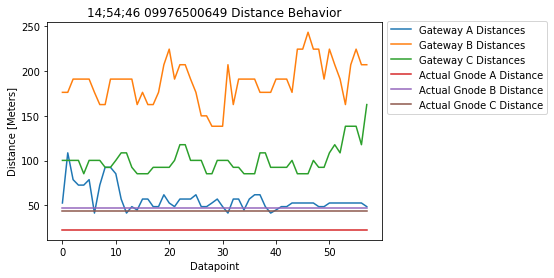

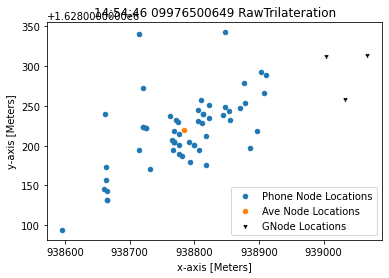

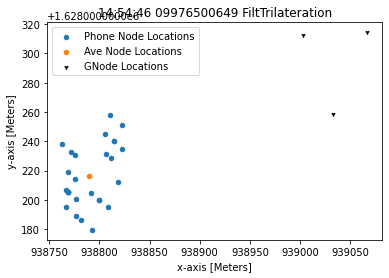

In [55]:
# Plot the behavior of the distance
plt.figure(fig)
plt.plot(distanceAf, label='Gateway A Distances')
plt.plot(distanceBf, label='Gateway B Distances')
plt.plot(distanceCf, label='Gateway C Distances')
plt.plot(np.arange(len(distanceAf)),np.ones([1,len(distanceAf)])[0]*comp_distanceAf, label='Actual Gnode A Distance')
plt.plot(np.arange(len(distanceAf)),np.ones([1,len(distanceAf)])[0]*comp_distanceBf, label='Actual Gnode B Distance')
plt.plot(np.arange(len(distanceAf)),np.ones([1,len(distanceAf)])[0]*comp_distanceCf, label='Actual Gnode C Distance')
plt.title(dtn + ' 0' + phoneA  + ' Distance Behavior')
plt.xlabel('Datapoint')
plt.ylabel('Distance [Meters]')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.03))
plt.savefig(save_destination + dtn + ' 0' + phoneA + ' DistanceBehavior.jpg', bbox_inches='tight')
fig += 1
# Plot the data for trilateration w/o the filters
plt.figure(fig)
plt.scatter(x, y, label='Phone Node Locations', cmap='brg', s=20)
plt.scatter(xAve, yAve, label='Ave Node Locations', cmap='brg', s=20)
plt.scatter(xg, yg, marker='1', label='GNode Locations', c='black', s=20)
plt.title(dtn + ' 0' + phoneA  + ' RawTrilateration')
plt.xlabel('x-axis [Meters]')
plt.ylabel('y-axis [Meters]')
plt.legend()
plt.savefig(save_destination + dtn + ' 0' + phoneA + ' RawTrilateration.jpg')
fig += 1
# Plot the data for trilateration w/ the filters
plt.figure(fig)
plt.scatter(xFilt, yFilt, label='Phone Node Locations', cmap='brg', s=20)
plt.scatter(xFiltAve, yFiltAve, label='Ave Node Locations', cmap='brg', s=20)
plt.scatter(xg, yg, marker='1', label='GNode Locations', c='black', s=20)
plt.title(dtn + ' 0' + phoneA  + ' FiltTrilateration')
plt.xlabel('x-axis [Meters]')
plt.ylabel('y-axis [Meters]')
plt.legend()
plt.savefig(save_destination + dtn + ' 0' + phoneA + ' FiltTrilateration.jpg')
fig += 1

In [56]:
# K-means
# K-means Clustering won't be performed if there is only 1 set of coordinates in the Dataset.
if len(xFilt)<2:
    quit()

# Create numpy array 'data' containing (x,y) coordinates
data = np.array([[xFilt[0],yFilt[0]]])
for i in range(1,len(xFilt)):
    data = np.append(data,[[xFilt[i],yFilt[i]]], axis=0)

# Duplicate Phone Coordinate Filter for K-means Convergence
data = np.unique(data, axis=0) #Eliminate Duplicates in data

kmeans,inertia,elbow = kmeansOptimize(data)
print('Optimal Number of Clusters is', elbow.knee)

Optimal Number of Clusters is 4


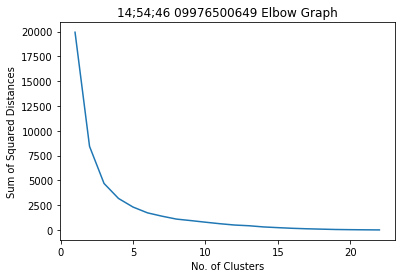

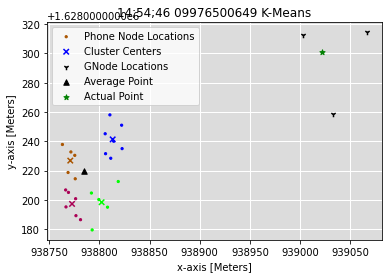

In [57]:
#Elbow Plot
plt.figure(fig)
plt.plot(range(1,len(data)), inertia)
plt.xlabel('No. of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title(dtn + ' 0' + phoneA  + ' Elbow Graph')
plt.savefig(save_destination + dtn + ' 0' + phoneA + ' Elbow.jpg') #Change Directory Accordingly
fig += 1

# K-means Plot
plt.figure(fig)
plt.scatter(data[:,0],data[:,1], c=kmeans.labels_, label = 'Phone Node Locations', cmap='brg', s=5)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c=list(range(1,elbow.knee+1)), marker = 'x', label = 'Cluster Centers', cmap='brg', s=30)
plt.scatter(xg, yg, marker='1', label='GNode Locations', c='black', s=30)
plt.scatter(xAve, yAve, marker='^', label='Average Point', c='black', s=30)
plt.scatter(xAct, yAct, marker='*', label='Actual Point', c='green', s=30)
plt.grid(linewidth=1, color="w")
ax = plt.gca()
ax.set_facecolor('gainsboro')
ax.set_axisbelow(True)
plt.xlabel('x-axis [Meters]')
plt.ylabel('y-axis [Meters]')
plt.title(dtn + ' 0' + phoneA  + ' K-Means')
plt.legend()
plt.savefig(save_destination + dtn + ' 0' + phoneA + ' K-Means.jpg') #Change Directory Accordingly
fig += 1

In [58]:
# Error Computations
# Computed Position vs. Actual Position
compVact, centVave, compVcent = errorcomp(x, y, xAct, yAct, kmeans, xAve, yAve, data)

In [59]:
###############CSV Writing############
with open(save_destination+'Basic.csv', mode='a') as blogs:
    blogswrite = csv.writer(blogs, dialect='excel', lineterminator='\n')
    blogswrite.writerow(['Time',dtn])
    blogswrite.writerow(['Phone#','0'+phoneA])
    blogswrite.writerow(['gnodeA',np.append(xg[0],yg[0])])
    blogswrite.writerow(['gnodeB',np.append(xg[1],yg[1])])
    blogswrite.writerow(['gnodeC',np.append(xg[2],yg[2])])
    blogswrite.writerow(['Mean Raw Distances'])
    blogswrite.writerow(['A','B','C'])
    blogswrite.writerow([AfAve,BfAve,CfAve])
    blogswrite.writerow(['Mean Raw X and Y Coordinates','','','',np.append(xAve,yAve)])
    blogswrite.writerow(['Mean Coordinates with Tolerance Filter','','','',np.append(xFiltAve,yFiltAve)])
    blogswrite.writerow(['Optimal # of Clusters','',elbow.knee])
    blogswrite.writerow([''])
    blogswrite.writerow([''])
    
with open(save_destination+'Actual.csv', mode='a') as alogs:
    alogswrite = csv.writer(alogs, dialect='excel', lineterminator='\n')
    alogswrite.writerow(['Time',dtn])
    alogswrite.writerow(['Phone#','0'+phoneA])
    alogswrite.writerow(['Actual Coordinates','',np.append(xAct,yAct)])
    alogswrite.writerow(['Actual Computed Distances from Gnodes'])
    alogswrite.writerow(['A','','B','','C'])
    alogswrite.writerow([comp_distanceAf,'',comp_distanceBf,'',comp_distanceCf])
    alogswrite.writerow(['Actual Position vs. Raw X and Y Coordinates'])
    for i in range(np.shape(compVact)[0]):
        alogswrite.writerow([compVact[i]])
    alogswrite.writerow([''])
    alogswrite.writerow([''])

with open(save_destination+'Coordinates.csv', mode='a') as clogs:
    clogswrite = csv.writer(clogs, dialect='excel', lineterminator='\n')
    clogswrite.writerow(['Time',dtn])
    clogswrite.writerow(['Phone#','0'+phoneA])
    clogswrite.writerow(['Raw X and Y Coordinates'])
    for i in range(np.shape(x)[0]):
        clogswrite.writerow([np.append(x[i],y[i])])
    clogswrite.writerow(['-------------------------------'])
    clogswrite.writerow(['Coordinates with Tolerance Filter'])
    for i in range(np.shape(xFilt)[0]):
        clogswrite.writerow([np.append(xFilt[i],yFilt[i])])
    clogswrite.writerow([''])
    clogswrite.writerow([''])
    
with open(save_destination+'Distances.csv', mode='a') as dlogs:
    dlogswrite = csv.writer(dlogs, dialect='excel', lineterminator='\n')
    dlogswrite.writerow(['Time',dtn])
    dlogswrite.writerow(['Phone#','0'+phoneA])
    dlogswrite.writerow(['Raw Distances'])
    dlogswrite.writerow(['A','B','C'])
    for i in range(len(distanceAf)):
        dlogswrite.writerow([distanceAf[i],distanceBf[i],distanceCf[i]])    
    dlogswrite.writerow([''])
    dlogswrite.writerow([''])
    
    with open(save_destination+'K-Means.csv', mode='a') as klogs:
        klogswrite = csv.writer(klogs, dialect='excel', lineterminator='\n')
        klogswrite.writerow(['Time',dtn])
        klogswrite.writerow(['Phone#','0'+phoneA])
        klogswrite.writerow(['Inertia'])
        for i in range(len(inertia)):
            klogswrite.writerow([inertia[i]]) 
        klogswrite.writerow(['K-Means Centroid Coordinates'])
        for i in range(elbow.knee):
            klogswrite.writerows([[np.append(kmeans.cluster_centers_[i,0],kmeans.cluster_centers_[i,1])]]) 
        klogswrite.writerow(['K-Means Centroids vs. Mean Coordinates with Tolerance Filter'])
        klogswrite.writerows([centVave])
        klogswrite.writerow(['K-Means Centroids vs. Coordinates w/ Tolerance Filter '])
        for i in range(len(compVcent)):    
            for j in range (len(compVcent[i])):
                klogswrite.writerow([compVcent[i][j]])
            klogswrite.writerow(['-------------------------------'])
        klogswrite.writerow([''])
        klogswrite.writerow([''])